<h1> Approach </h1>
gaussian subsampling OR FFT preprocessing -> CNN + RNN https://github.com/anlthms/sp-2016

<h1> Notes </h1>
https://workflowy.com/s/sKHWm3chWc

<h1> Domain Tools </h1>
EEGrunt: A Collection Python EEG (+ ECG) Analysis Utilities for OpenBCI and Muse
https://github.com/curiositry/EEGrunt

Intro to MEG and EEG processing with MNE and Python
http://mne-tools.github.io/mne-python-intro/

MNE: MEG + EEG Analysis and visualization
MNE is a community-driven software package designed for processing electroencephalography (EEG) and magnetoencephalography (MEG) data
http://martinos.org/mne/stable/index.html

EEG Tools: Collection of Python modules for EEG analysis. Includes EDF+ and BDF loaders, scalp plots and commonly used spatial filters.
https://github.com/breuderink/eegtools

In [7]:
# translation of the Matlab feature extractor
import sys
import os
import numpy as np
import pandas as pd
from math import *
from scipy.io import loadmat
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
%matplotlib inline
#import pyeeg
# pyeeg is the one that has very good fractal dimensions 
# computation but not installed here

In [4]:
def mat_to_data(path):
    mat = loadmat(path)
    names = mat['dataStruct'].dtype.names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    return ndata

def corr(data,type_corr):
    C = np.array(data.corr(type_corr))
    C[np.isnan(C)] = 0
    C[np.isinf(C)] = 0
    w,v = np.linalg.eig(C)
    #print(w)
    x = np.sort(w)
    x = np.real(x)
    return x

def calculate_features(file_name):
    f = mat_to_data(file_name)
    fs = f['iEEGsamplingRate'][0,0]
    eegData = f['data']
    [nt, nc] = eegData.shape
    print((nt, nc))
    subsampLen = floor(fs * 60)
    numSamps = int(floor(nt / subsampLen));      # Num of 1-min samples
    sampIdx = range(0,(numSamps+1)*subsampLen,subsampLen)
    #print(sampIdx)
    feat = [] # Feature Vector
    for i in range(1, numSamps+1):
        print('processing file {} epoch {}'.format(file_name,i))
        epoch = eegData[sampIdx[i-1]:sampIdx[i], :]

        # compute Shannon's entropy, spectral edge and correlation matrix
        # segments corresponding to frequency bands
        lvl = np.array([0.1, 4, 8, 12, 30, 70, 180])  # Frequency levels in Hz
        lseg = np.round(nt/fs*lvl).astype('int')
        D = np.absolute(np.fft.fft(epoch, n=lseg[-1], axis=0))
        D[0,:]=0                                # set the DC component to zero
        D /= D.sum()                      # Normalize each channel               
        
        dspect = np.zeros((len(lvl)-1,nc))
        for j in range(len(dspect)):
            dspect[j,:] = 2*np.sum(D[lseg[j]:lseg[j+1],:], axis=0)

        # Find the shannon's entropy
        spentropy = -1*np.sum(np.multiply(dspect,np.log(dspect)), axis=0)

        # Find the spectral edge frequency
        sfreq = fs
        tfreq = 40
        ppow = 0.5

        topfreq = int(round(nt/sfreq*tfreq))+1
        A = np.cumsum(D[:topfreq,:])
        B = A - (A.max()*ppow)
        spedge = np.min(np.abs(B))
        spedge = (spedge - 1)/(topfreq-1)*tfreq

        # Calculate correlation matrix and its eigenvalues (b/w channels)
        data = pd.DataFrame(data=epoch)
        type_corr = 'pearson'
        lxchannels = corr(data, type_corr)
        
        # Calculate correlation matrix and its eigenvalues (b/w freq)
        data = pd.DataFrame(data=dspect)
        lxfreqbands = corr(data, type_corr)
        
        # Spectral entropy for dyadic bands
        # Find number of dyadic levels
        ldat = int(floor(nt/2.0))
        no_levels = int(floor(log(ldat,2.0)))
        seg = floor(ldat/pow(2.0, no_levels-1))

        # Find the power spectrum at each dyadic level
        dspect = np.zeros((no_levels,nc))
        for j in range(no_levels-1,-1,-1):
            dspect[j,:] = 2*np.sum(D[int(floor(ldat/2.0))+1:ldat,:], axis=0)
            ldat = int(floor(ldat/2.0))

        # Find the Shannon's entropy
        spentropyDyd = -1*np.sum(np.multiply(dspect,np.log(dspect)), axis=0)

        # Find correlation between channels
        data = pd.DataFrame(data=dspect)
        lxchannelsDyd = corr(data, type_corr)
        
        # Fractal dimensions
        no_channels = nc
        #fd = np.zeros((2,no_channels))
        #for j in range(no_channels):
        #    fd[0,j] = pyeeg.pfd(epoch[:,j])
        #    fd[1,j] = pyeeg.hfd(epoch[:,j],3)
        #    fd[2,j] = pyeeg.hurst(epoch[:,j])

        #[mobility[j], complexity[j]] = pyeeg.hjorth(epoch[:,j)
        # Hjorth parameters
        # Activity
        activity = np.var(epoch, axis=0)
        #print('Activity shape: {}'.format(activity.shape))
        # Mobility
        mobility = np.divide(
                            np.std(np.diff(epoch, axis=0)), 
                            np.std(epoch, axis=0))
        #print('Mobility shape: {}'.format(mobility.shape))
        # Complexity
        complexity = np.divide(np.divide(
                                        # std of second derivative for each channel
                                        np.std(np.diff(np.diff(epoch, axis=0), axis=0), axis=0),
                                        # std of second derivative for each channel
                                        np.std(np.diff(epoch, axis=0), axis=0))
                               , mobility)
        #print('Complexity shape: {}'.format(complexity.shape))
        # Statistical properties
        # Skewness
        sk = skew(epoch)

        # Kurtosis
        kurt = kurtosis(epoch)

        # compile all the features
        feat = np.concatenate((feat,
                               spentropy.ravel(),
                               spedge.ravel(),
                               lxchannels.ravel(),
                               lxfreqbands.ravel(),
                               spentropyDyd.ravel(),
                               lxchannelsDyd.ravel(),
                               #fd.ravel(),
                               activity.ravel(),
                               mobility.ravel(),
                               complexity.ravel(),
                               sk.ravel(),
                               kurt.ravel()
                                ))

    return feat

In [8]:
file_name = "/Users/davisdulin/src/kaggle/1_1_0.mat"
f = mat_to_data(file_name)
fs = f['iEEGsamplingRate'][0,0]
eegData = f['data']
[nt, nc] = eegData.shape

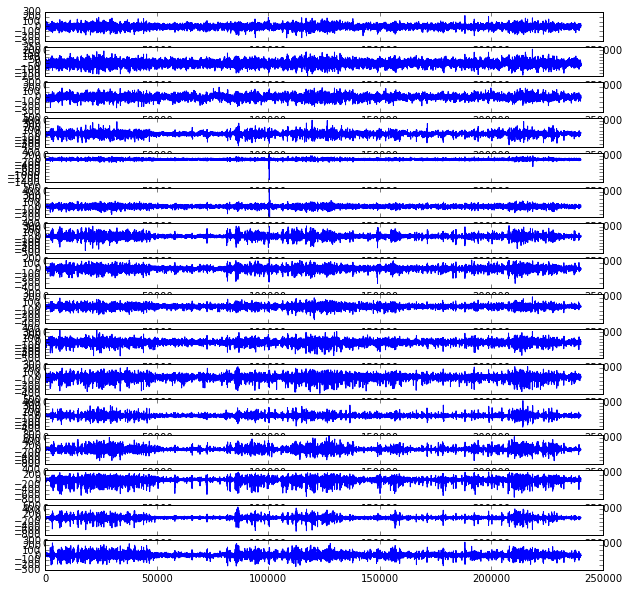

In [9]:
fig, axs = plt.subplots(eegData.shape[1], figsize=(10,10))
for nn, ax in enumerate(axs):
    ax.plot(eegData[:,nn])
# eegData.shape


In [30]:
#TODO: label dropout in the data for training

# for d in eegData[:,1]:
#     win_min = max(0,d-10000)
#     win_max = min(len(eegData[:,1]), d+10000)
#     consecutive_zero_cnt = 0
#     if d == 0:
# accel = np.diff(eegData[:,1], n=2)
# consec = 0
# is_dropout = False
# for i, d in enumerate(np.argwhere(accel == 0)):
#     if d == 0:
#         consec += 1
#     if consec > 15000:
#         is_dropout = True
#         begin_dropout = max(0,20000)
#     if d != 0:
#         consec = 0
#         if is_dropout:
#             end_dropout = d - 1
#             delete_from_array(begin_dropout, end_dropout, eegData)
#         is_dropout = False
# if is_dropout == True:            

[ 20.06667709 -64.99739075  -2.78955483 -22.48268318]


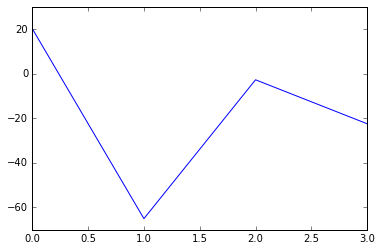

In [29]:
file_name = "/Users/davisdulin/src/kaggle/1_1_0.mat"
f = mat_to_data(file_name)
fs = f['iEEGsamplingRate'][0,0]
eegData = f['data']
[nt, nc] = eegData.shape
#print(nt)
#print(nc)

def gauss_kern_1d(size, factor=1.5):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    x = np.arange(-int(size*factor), int(size*factor)+1)
    g = np.exp(-(x**2/size))
    return g / g.sum()

smoothed_data = list()
for channel in range(15):
    smoothed_data.append(np.convolve(eegData[:,channel], gauss_kern_1d(3), mode="same"))
    
plt.plot(eegData[1][1:5])
print(eegData[1][1:5])

[ 17.2428955   16.28972213  14.24177263  13.2016072 ]


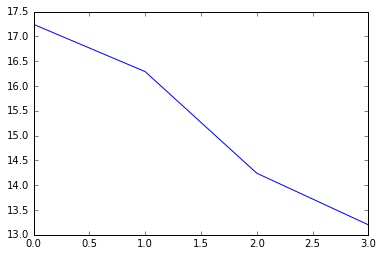

In [28]:
plt.plot(smoothed_data[1][1:5])
print(smoothed_data[1][1:5])

In [ ]:
# 1) need to loop over files
# 2) need output file type. .wav?